In [11]:
# Basic python packages
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Packages related to images
from PIL import Image
import PIL


In [12]:
def clean_data(path):
    df = pd.read_csv(path)
    df = df[df['Creator'] != ''] 
    df = df[df['Creator'] != 'anoniem']
    df = df[df['Creator'] != 'onbekend']
    df = df[df['Creator'].notna()]
    df = df.replace('Koning, Cornelis (?-1671)', 'Koning, Cornelis')
    return df

def preprocess_data(df, num_artworks = 10):
    df = df.groupby("Creator").filter(lambda x: len(x) >= num_artworks)
    return df

df = clean_data('../Data/Rijksmuseum/xml_files.csv')
rijksdata = preprocess_data(df, 100)

In [13]:
rijksdata

,Identifier,Creator,Title,Date,Type
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz",Keizer Karel V omgeven door zijn overwonnen te...,1555 - 1555,prent
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz",Gevangename van Frans I tijdens de slag van Pa...,1555 - 1556,prent
7,RP-P-1992-70,"Hondius, Hendrick (I)",Vanitasstilleven met een schedel met lauwerkra...,1626 - 1626,prent
100,RP-T-1905-158(R),"Fokke, Simon","Jonge edelman, naar links in gebogen houding",1710 - 1779,tekening
101,RP-T-1905-158(V),"Fokke, Simon",Zittende man,ca. 1710 - ca. 1779,tekening
...,...,...,...,...,...
111961,RP-P-OB-103.253,"Galle, Cornelis (I)",Maria met Kind en de H. Bernardus van Siena en...,1612 - 1633,prent
111962,RP-P-OB-103.254,"Galle, Cornelis (I)",Petrus doopt de H. Prisca van Rome,ca. 1586 - ca. 1610,prent
111965,RP-P-OB-103.259,"Natalis, Michel",H. Franciscus van Assisi,1620 - 1668,prent
111966,RP-P-OB-103.260,"Sadeler, Johann (I)",Heilige Apollonia (),1583 - 1587,prent


In [14]:
#Paths to different folders/files
img_list = glob.glob("../Data/Rijksmuseum/jpg2/*.jpg")
image_dir = "../Data/Rijksmuseum/jpg2/"
split_image_dir = "../Data/Rijksmuseum/jpg2_split_100/"

n_labels = len(rijksdata.groupby('Creator').count())

In [15]:
n_labels

183

In [16]:
# labels = pd.read_csv(labels_file)
labels = rijksdata[['Identifier', 'Creator']]
labels

,Identifier,Creator
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz"
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz"
7,RP-P-1992-70,"Hondius, Hendrick (I)"
100,RP-T-1905-158(R),"Fokke, Simon"
101,RP-T-1905-158(V),"Fokke, Simon"
...,...,...
111961,RP-P-OB-103.253,"Galle, Cornelis (I)"
111962,RP-P-OB-103.254,"Galle, Cornelis (I)"
111965,RP-P-OB-103.259,"Natalis, Michel"
111966,RP-P-OB-103.260,"Sadeler, Johann (I)"


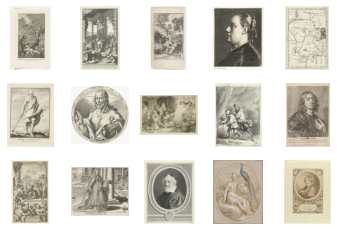

In [17]:
def plot_random_images(img_names, n_x=2, n_y=2, seed=0):
    """
    Plots random images from de data set in a n_x by n_y grid

    :image_names: List with the names of all images
    :n_x: Height of the grid
    :n_x: Width of the grid
    :seed: Seed for the random sample
    :return: nothing
    """ 
    f, axs = plt.subplots(n_x, n_y)
    sample = img_names.sample(n_x * n_y, random_state=seed)
    c = 0
    for x in range(n_x):
        for y in range(n_y):
            img_loc = [item for item in img_list if sample.iloc[c] in item][0]
            img = plt.imread(img_loc)
            axs[x, y].imshow(img)
            axs[x, y].axis('off')
            c += 1

plot_random_images(labels["Identifier"], 3, 5)

In [18]:
labels['Creator'].iloc[0]

'Coornhert, Dirck Volckertsz'

# Reformat data for learning
To be able to load the data with a generator. We must split the training and validation data and place them into a folder based on their label.

In [19]:
def generate_label_folders(image_path, image_names, image_labels, destination_path):
    """
    Splits a single folder with images into multiple folders where images are placed based on their labels.

    :image_path: path to the folder with the images
    :image_names: A numpy array with the names of all images
    :image_labels: A numpy array with the labels of all images
    :destination_path: Path of the folder where the images are placed into
    :return: Nothing
    """ 
    for i in range(len(image_names)):
        if i % 522 == 0:
            print(str(round(i/len(image_names)*100, 3)) + '%')
            
        # Check if the directory exists. Else, make one
        isExist = os.path.exists(os.path.join(destination_path, str(image_labels.iloc[i])))
        if not isExist:
            os.makedirs(os.path.join(destination_path, str(image_labels.iloc[i])))
            
        # Copy the image
        img_loc = [item for item in img_list if image_names.iloc[i] in item][0]
        img = Image.open(img_loc)
        img.save(destination_path + "/" + str(image_labels.iloc[i]) + "/" + image_names.iloc[i] + ".jpg")
        

generate_label_folders(image_dir, labels["Identifier"], labels["Creator"], split_image_dir)

0.0%
0.999%
1.998%
2.997%
3.997%
4.996%
5.995%
6.994%
7.993%
8.992%
9.991%
10.991%
11.99%
12.989%
13.988%
14.987%
15.986%
16.985%
17.984%
18.984%
19.983%
20.982%
21.981%
22.98%
23.979%
24.978%
25.978%
26.977%
27.976%
28.975%
29.974%
30.973%
31.972%
32.972%
33.971%
34.97%
35.969%
36.968%
37.967%
38.966%
39.966%
40.965%
41.964%
42.963%
43.962%
44.961%
45.96%
46.96%
47.959%
48.958%
49.957%
50.956%
51.955%
52.954%
53.953%
54.953%
55.952%
56.951%
57.95%
58.949%
59.948%
60.947%
61.947%
62.946%
63.945%
64.944%
65.943%
66.942%
67.941%
68.941%
69.94%
70.939%
71.938%
72.937%
73.936%
74.935%
75.935%
76.934%
77.933%
78.932%
79.931%
80.93%
81.929%
82.929%
83.928%
84.927%
85.926%
86.925%
87.924%
88.923%
89.922%
90.922%
91.921%
92.92%
93.919%
94.918%
95.917%
96.916%
97.916%
98.915%
99.914%
